# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [1]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

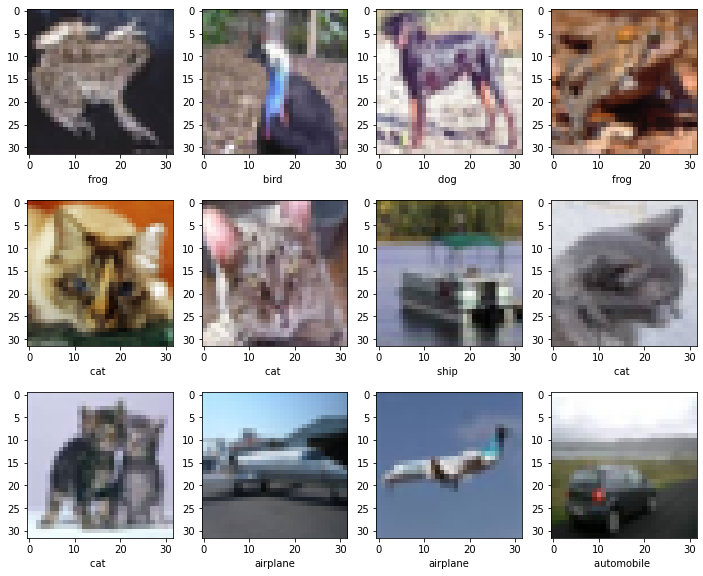

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [6]:
import keras
from keras import layers as L
from keras import backend as K

In [33]:
model = keras.Sequential()
model.add(L.Flatten(input_shape=(32, 32, 3)))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(32, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 795,242
Trainable params: 795,242
Non-trainable params: 0
_________________________________________________________________


In [35]:
dummy_pred = model.predict_proba(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [15]:
from keras.utils import to_categorical

In [16]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [29]:
# помещаю в коллбэк чекпойнты в конце эпох
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='1st_model.{epoch:02d}-{val_accuracy:.2f}.h5')
]

In [16]:
# model.compile(# Your code here)
# model.fit(# Your code here)

In [36]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.fit(
    X_train,
    y_train,
    batch_size=80,
    epochs=20,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
)

Epoch 1/20
500/500 [==============================] - 3s 6ms/step - loss: 1.5617 - accuracy: 0.4504 - val_loss: 1.6379 - val_accuracy: 0.4148
Epoch 2/20
500/500 [==============================] - 3s 7ms/step - loss: 1.5431 - accuracy: 0.4575 - val_loss: 1.5844 - val_accuracy: 0.4374
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 1.5184 - accuracy: 0.4656 - val_loss: 1.5539 - val_accuracy: 0.4508
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 1.4989 - accuracy: 0.4735 - val_loss: 1.5329 - val_accuracy: 0.4599
Epoch 5/20
500/500 [==============================] - 3s 7ms/step - loss: 1.4814 - accuracy: 0.4780 - val_loss: 1.5134 - val_accuracy: 0.4636
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 1.4619 - accuracy: 0.4855 - val_loss: 1.5129 - val_accuracy: 0.4602
Epoch 7/20
500/500 [==============================] - 3s 6ms/step - loss: 1.4483 - accuracy: 0.4870 - val_loss: 1.4873 - val_accuracy: 0.4738
Epoch 

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [39]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5
 Not bad!


Заданного в 40% порога точности нейросеть достигла. Если мы визуализируем часть предсказанных ею классов изображений из отложенной тестовой выборки, то увидим как правильные, так и неправильные метки классов (неправильных пока больше)

In [40]:
y_pred_test = model.predict(X_test)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

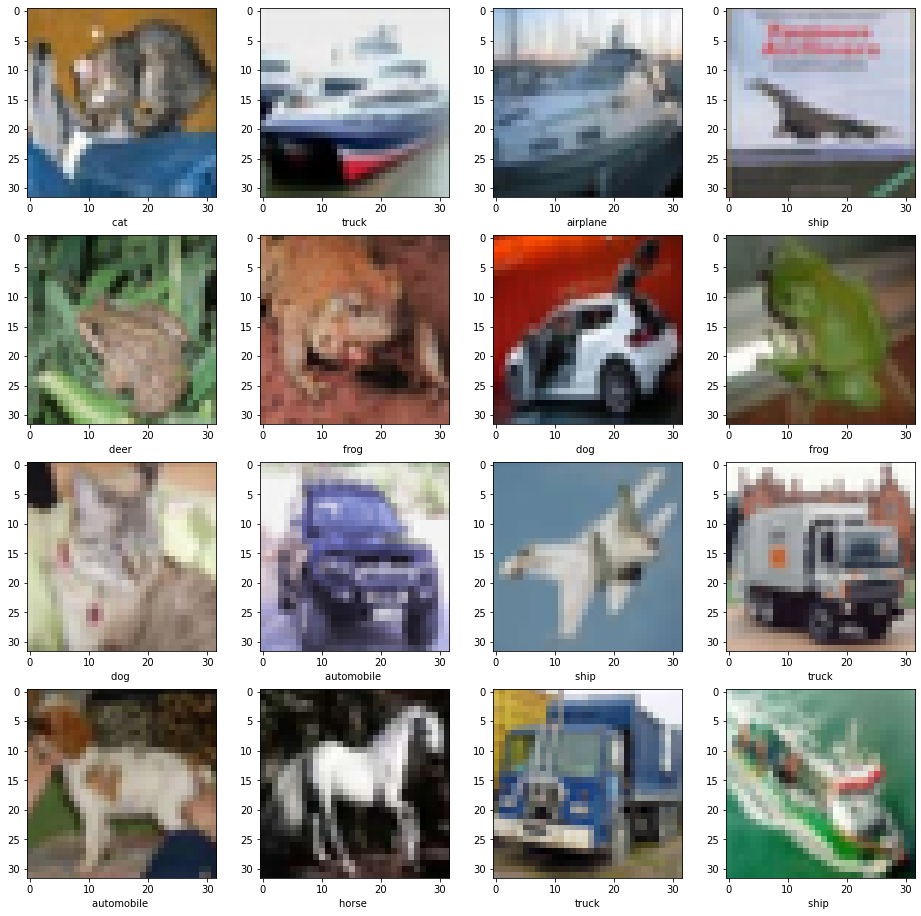

In [41]:
plt.figure(figsize=[16,16])
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xlabel(class_names[y_pred_test_labels[i]])
    plt.imshow(X_test[i])

In [42]:
model.save('1st_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 1st_model\assets


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [43]:
cnn_model = keras.Sequential()
cnn_model.add(L.convolutional.Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
cnn_model.add(L.MaxPooling2D((2, 2)))
cnn_model.add(L.Flatten())
cnn_model.add(L.Dense(100, activation='relu'))
cnn_model.add(L.Dense(10, activation='softmax'))

In [44]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               225100    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 226,390
Trainable params: 226,390
Non-trainable params: 0
_________________________________________________________________


In [45]:
cnn_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
# запускаю обучение с теми же параметрами, что и для полносвязной сети
cnn_model.fit(
    X_train,
    y_train,
    batch_size=80,
    epochs=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 2.0959 - accuracy: 0.2467 - val_loss: 1.9632 - val_accuracy: 0.2980
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 1.8863 - accuracy: 0.3347 - val_loss: 1.8159 - val_accuracy: 0.3631
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 1.7708 - accuracy: 0.3814 - val_loss: 1.7325 - val_accuracy: 0.3899
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 1.6724 - accuracy: 0.4141 - val_loss: 1.6709 - val_accuracy: 0.3994
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 1.5830 - accuracy: 0.4454 - val_loss: 1.5584 - val_accuracy: 0.4401
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 1.5115 - accuracy: 0.4711 - val_loss: 1.4944 - val_accuracy: 0.4624
Epoch 7/20
500/500 [==============================] - 7s 15ms/step - loss: 1.4529 - accuracy: 0.4889 - val_loss: 1.4438 - val_accuracy: 0.4816

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [47]:
# from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, cnn_model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5693
 Not bad!


С добавлением  сверточного слоя показатель accuracy вырос с ~50% до ~57%. Если визуализировать те же картинки, что и на предыдущем этапе, изображений, размеченных верно, станет больше.

In [48]:
y_pred_test = cnn_model.predict(X_test)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

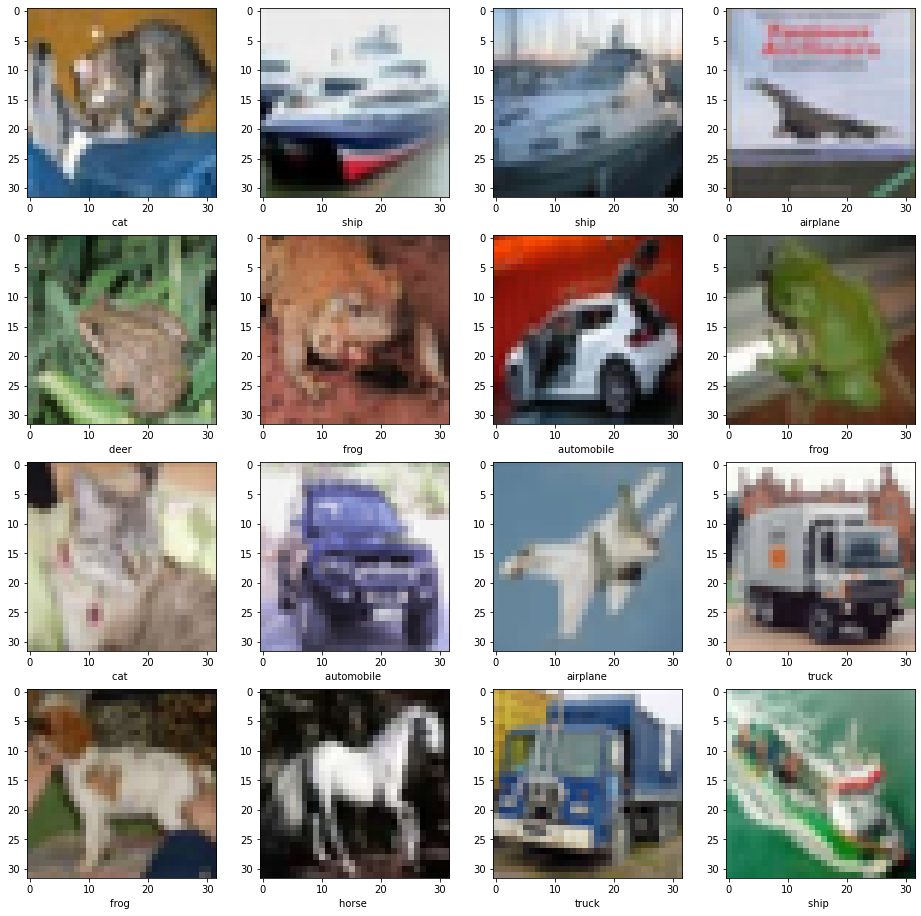

In [49]:
plt.figure(figsize=[16,16])
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xlabel(class_names[y_pred_test_labels[i]])
    plt.imshow(X_test[i])

In [ ]:
cnn_model.save('1st_cnn_model')

## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [50]:
import tqdm 

In [54]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict_classes(X_test))))

In [68]:
!rm -rf ./logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [56]:
optimizers = {
    'sgd_default': keras.optimizers.SGD(),
    'sgd_nest': keras.optimizers.SGD(nesterov=True, momentum=0.9),
    'adam': keras.optimizers.Adam(),
    'rmsprop': keras.optimizers.RMSprop()

}

models = {'simple_model': model, 'cnn_model':cnn_model}

In [71]:
evaluator = Evaluator(models, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val),max_epochs=20, batch_size=80)
evaluator.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/8 [00:00<?, ?it/s]

Final score of simple_model_sgd_default is 0.4884
Final score of simple_model_sgd_nest is 0.5109
Final score of simple_model_adam is 0.1
Final score of simple_model_rmsprop is 0.465
Final score of cnn_model_sgd_default is 0.4905
Final score of cnn_model_sgd_nest is 0.5774
Final score of cnn_model_adam is 0.5684
Final score of cnn_model_rmsprop is 0.6172


In [73]:
evaluator1 = Evaluator({'test':model}, optimizers={'Adam':keras.optimizers.Adam()})
evaluator1.fit(X_train, y_train, validation_data=(X_val, y_val),max_epochs=20, batch_size=80)
evaluator1.evaluate(X_test, y_test, accuracy_score)

  0%|          | 0/1 [00:00<?, ?it/s]

Final score of test_Adam is 0.4881


Прокомментируйте полученные результаты.

Посмотрим на графики loss функций, полученный с помощью Tensorboard. 

В случае с обычной моделью и оптимайзером Adam при нескольких запусках ячейки у меня происходил странный сбой, в результате которого сеть оставалась необученной, её точность не менялась. При этом абсолютно идентичный код, запущенный специально для одной модели - полносвязной, и для одного оптимайзера - Adam, выдавал вполне себе адекватный результат. С этим до конца не разобралась, т.к. каждый запуск с полным циклом отнимает много времени, но на графиках свожу результаты воедино и для сразу  отработавших методов и для отдельного Adam

Для полносвязной модели результаты ниже:

![Epoch_loss_train](img/Epoch_loss_train.jpg)
![Epoch_loss_val](img/Epoch_loss_val.jpg)

Для сверточной - результаты ниже:

![Epoch_loss_train_cnn](img/Epoch_loss_train_cnn.jpg)
![Epoch_loss_val_cnn](img/Epoch_loss_val_cnn.jpg)

В случае с полносвязной сеткой loss на трейне убывает примерно с одинаковой скоростью, и модель, с наименьшим начальным значением loss после 20 эпох соответственно и показала минимальное значение функции потерь среди всех остальных. Этой моделью оказалаь сетка с оптимайзером SGD с добавлением nesterov momentum. На валидации loss-ы убывают не монотонно, с небольшими колебаниями, однако роста ошибки не происходит, что хорошо. Нестеров моментум снова показывает лучший результат.

В случае со сверточной сетью похоже, что мы столкнулись с проблемой переобучения. На трейне loss ожидаемо падает у всех алгоритмов, но на валидации loss падает только у SGD с аргументами по умолчанию, у остальных же - с какой-то эпохи начинает расти. Поэтому в данном случае SGD отработал лучше остальных: его финальная accuracy меньше, чем у остальных алгоритмов, но он хотя бы не переобучился. Возможно, для прочих алгоритмов потребовалось бы меньшее количество эпох.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [74]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [77]:
# сверточная сеть с нормализацией по батчу
cnn_upd_model = keras.Sequential()
cnn_upd_model.add(L.InputLayer(input_shape=(32, 32, 3)))
cnn_upd_model.add(L.convolutional.Conv2D(filters=10, kernel_size=(3, 3)))
cnn_upd_model.add(L.MaxPooling2D((2, 2)))
cnn_upd_model.add(L.BatchNormalization())
cnn_upd_model.add(L.Activation('relu'))
cnn_upd_model.add(L.Flatten())
cnn_upd_model.add(L.Dense(100, activation='relu'))
cnn_upd_model.add(L.Dense(10, activation='softmax'))

In [78]:
cnn_upd_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 10)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 10)        40        
_________________________________________________________________
activation (Activation)      (None, 15, 15, 10)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2250)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               225100    
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [79]:
cnn_upd_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
cnn_upd_model.fit(
    X_train,
    y_train,
    batch_size=80,
    epochs=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.7603 - accuracy: 0.3778 - val_loss: 1.5942 - val_accuracy: 0.4384
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 1.4534 - accuracy: 0.4897 - val_loss: 1.4440 - val_accuracy: 0.4898
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 1.3235 - accuracy: 0.5364 - val_loss: 1.3482 - val_accuracy: 0.5273
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 1.2425 - accuracy: 0.5643 - val_loss: 1.2916 - val_accuracy: 0.5511
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 1.1854 - accuracy: 0.5838 - val_loss: 1.2552 - val_accuracy: 0.5636
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 1.1338 - accuracy: 0.6029 - val_loss: 1.2574 - val_accuracy: 0.5669
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 1.0917 - accuracy: 0.6202 - val_loss: 1.2580 - val_accuracy:

In [81]:
test_acc = accuracy_score(y_test, cnn_upd_model.predict_classes(X_test))
print(test_acc)

0.5908


In [114]:
# полносвязная сеть с нормализациями по батчу
upd_model = keras.Sequential()
upd_model.add(L.InputLayer(input_shape=(32, 32, 3)))
upd_model.add(L.BatchNormalization())
upd_model.add(L.Flatten())
upd_model.add(L.Dense(256, activation='relu'))
upd_model.add(L.BatchNormalization())
upd_model.add(L.Dense(32, activation='relu'))
upd_model.add(L.BatchNormalization())
upd_model.add(L.Dense(10, activation='softmax'))

In [96]:
upd_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
flatten_9 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_26 (Dense)             (None, 32)                8224      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_27 (Dense)             (None, 10)              

In [115]:
upd_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [120]:
upd_model.fit(
    X_train,
    y_train,
    batch_size=80,
    epochs=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20
500/500 [==============================] - 13s 25ms/step - loss: 1.6397 - accuracy: 0.4266 - val_loss: 1.5911 - val_accuracy: 0.4420
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 1.5167 - accuracy: 0.4706 - val_loss: 1.5311 - val_accuracy: 0.4672
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 1.4320 - accuracy: 0.5005 - val_loss: 1.5042 - val_accuracy: 0.4723
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 1.3684 - accuracy: 0.5208 - val_loss: 1.4716 - val_accuracy: 0.4859
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 1.3143 - accuracy: 0.5431 - val_loss: 1.4484 - val_accuracy: 0.4911
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 1.2675 - accuracy: 0.5547 - val_loss: 1.4502 - val_accuracy: 0.4939
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 1.2250 - accuracy: 0.5703 - val_loss: 1.4485 - val_accuracy:

In [121]:
test_acc = accuracy_score(y_test, upd_model.predict_classes(X_test))
print(test_acc)

0.5052


Прокомментируйте полученные результаты.

У сверточной сети accuracy с добавлением нормализации поднялась с 56% до 59%

У полносвязной сети accuracy с добавлением нормализации поднялась незначительно и осталось в районе 50%

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [104]:
cnn_upd_model = keras.models.load_model('1st_cnn_model')

In [105]:
sizes = [32, 64, 80, 128, 256, 400, 512]


In [101]:
# объект этого класса обеспечит остановку в момент достижения заданного порога val_accuracy
from keras.callbacks import Callback

class EarlyStoppingValAcc(Callback):
    def __init__(self, monitor='val_accuracy', value=0.55, verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current > self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [114]:
my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.55, mode='min', patience=3)
     EarlyStoppingValAcc(monitor='val_accuracy', value=0.55, verbose=1)
]

In [96]:
# Функция для сброса весов, чтобы модель обучалась с нуля при каждом новом значении batch size
def reset_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and \
                hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])

In [115]:
# пробуем обучить модель, используя различные batch_size
for b_size in sizes:
    reset_weights(cnn_upd_model)   #сброс весов 
    print(b_size)
    cnn_upd_model.fit(
        X_train,
        y_train,
        batch_size=b_size,
        epochs=100,
        callbacks=my_callbacks,
        validation_data=(X_val, y_val)
    )
    print()

32
Epoch 1/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9456 - accuracy: 0.3014 - val_loss: 1.7586 - val_accuracy: 0.3757
Epoch 2/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6623 - accuracy: 0.4115 - val_loss: 1.5801 - val_accuracy: 0.4351
Epoch 3/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5190 - accuracy: 0.4616 - val_loss: 1.4834 - val_accuracy: 0.4675
Epoch 4/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4337 - accuracy: 0.4918 - val_loss: 1.4157 - val_accuracy: 0.4899
Epoch 5/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.3707 - accuracy: 0.5151 - val_loss: 1.3773 - val_accuracy: 0.5115
Epoch 6/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.3108 - accuracy: 0.5388 - val_loss: 1.3116 - val_accuracy: 0.5357
Epoch 7/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.2575 - accuracy: 0.5569 - val_loss: 1.268

Epoch 42/100
157/157 [==============================] - 7s 46ms/step - loss: 1.3015 - accuracy: 0.5441 - val_loss: 1.4875 - val_accuracy: 0.4667
Epoch 43/100
157/157 [==============================] - 7s 46ms/step - loss: 1.2961 - accuracy: 0.5444 - val_loss: 1.4789 - val_accuracy: 0.4698
Epoch 44/100
157/157 [==============================] - 7s 46ms/step - loss: 1.2917 - accuracy: 0.5470 - val_loss: 1.4982 - val_accuracy: 0.4536
Epoch 45/100
157/157 [==============================] - 7s 47ms/step - loss: 1.2836 - accuracy: 0.5517 - val_loss: 1.3795 - val_accuracy: 0.5153
Epoch 46/100
157/157 [==============================] - 7s 47ms/step - loss: 1.2813 - accuracy: 0.5526 - val_loss: 1.4669 - val_accuracy: 0.4765
Epoch 47/100
157/157 [==============================] - 7s 46ms/step - loss: 1.2740 - accuracy: 0.5544 - val_loss: 1.4183 - val_accuracy: 0.4957
Epoch 48/100
157/157 [==============================] - 7s 47ms/step - loss: 1.2645 - accuracy: 0.5570 - val_loss: 1.3688 - val_ac

Epoch 26/100
100/100 [==============================] - 7s 67ms/step - loss: 1.5170 - accuracy: 0.4652 - val_loss: 1.5395 - val_accuracy: 0.4544
Epoch 27/100
100/100 [==============================] - 7s 67ms/step - loss: 1.5213 - accuracy: 0.4637 - val_loss: 1.5301 - val_accuracy: 0.4590
Epoch 28/100
100/100 [==============================] - 7s 67ms/step - loss: 1.5051 - accuracy: 0.4694 - val_loss: 1.5181 - val_accuracy: 0.4672
Epoch 29/100
100/100 [==============================] - 7s 68ms/step - loss: 1.5015 - accuracy: 0.4715 - val_loss: 1.5140 - val_accuracy: 0.4658
Epoch 30/100
100/100 [==============================] - 7s 67ms/step - loss: 1.4897 - accuracy: 0.4756 - val_loss: 1.5026 - val_accuracy: 0.4662
Epoch 31/100
100/100 [==============================] - 7s 68ms/step - loss: 1.4818 - accuracy: 0.4784 - val_loss: 1.5037 - val_accuracy: 0.4680
Epoch 32/100
100/100 [==============================] - 7s 68ms/step - loss: 1.4729 - accuracy: 0.4820 - val_loss: 1.5251 - val_ac

79/79 [==============================] - 6s 80ms/step - loss: 1.3768 - accuracy: 0.5145 - val_loss: 1.6333 - val_accuracy: 0.4303
Epoch 52/100
79/79 [==============================] - 6s 80ms/step - loss: 1.3771 - accuracy: 0.5145 - val_loss: 1.5773 - val_accuracy: 0.4338
Epoch 53/100
79/79 [==============================] - 6s 79ms/step - loss: 1.3695 - accuracy: 0.5177 - val_loss: 1.4674 - val_accuracy: 0.4718
Epoch 54/100
79/79 [==============================] - 6s 80ms/step - loss: 1.3606 - accuracy: 0.5186 - val_loss: 1.5269 - val_accuracy: 0.4397
Epoch 55/100
79/79 [==============================] - 6s 80ms/step - loss: 1.3599 - accuracy: 0.5214 - val_loss: 1.4690 - val_accuracy: 0.4782
Epoch 56/100
79/79 [==============================] - 6s 80ms/step - loss: 1.3549 - accuracy: 0.5210 - val_loss: 1.5147 - val_accuracy: 0.4626
Epoch 57/100
79/79 [==============================] - 6s 79ms/step - loss: 1.3491 - accuracy: 0.5256 - val_loss: 1.5770 - val_accuracy: 0.4482
Epoch 58/100

- Batch size 32 - 7 эпох
- Batch size 64 - 12 эпох
- Batch size 80 - 25 эпох
- Batch size 128 - 25 эпох
- Batch size 256 - 72 эпохи
- Batch size 400 - 87 эпох
- Batch size 512 - не 100 эпох к заданной точности не сошлось

При наименьшем из имеющихся batch size модель сошлась к заданной точности быстрее всего

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [38]:
# функция для вывода графиков по loss и accuracy
def summarize_diagnostics(history):
    
    pyplot.figure(figsize=(10,8))

    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')

    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')


In [8]:
# для удобства - функция для вывода значения accuracy на тестовой выборке
def return_acc(model, x_test, y_test):
    test_acc = accuracy_score(y_test, model.predict_classes(x_test))
    return test_acc

Не буду использовать предобученную сеть, создам еще одну с нуля.  
для начала использую два сверточных слоя вместо одного

In [29]:

final_model = keras.Sequential()
final_model.add(L.InputLayer(input_shape=(32, 32, 3)))
final_model.add(L.convolutional.Conv2D(filters=10, kernel_size=(3, 3), activation='relu'))
final_model.add(L.convolutional.Conv2D(filters=10, kernel_size=(3, 3), activation='relu'))
final_model.add(L.MaxPooling2D((2, 2)))

final_model.add(L.Flatten())
final_model.add(L.Dense(100, activation='relu'))
final_model.add(L.Dense(10, activation='softmax'))

final_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [116]:
final_model.save('final_model_v1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: final_model_v1\assets


In [118]:
history = final_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStoppingValAcc(monitor='val_accuracy', value=0.8, verbose=1)]
)

Epoch 1/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.6632 - accuracy: 0.4060 - val_loss: 1.4530 - val_accuracy: 0.4804
Epoch 2/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.3437 - accuracy: 0.5245 - val_loss: 1.2867 - val_accuracy: 0.5472
Epoch 3/40
1250/1250 [==============================] - 24s 19ms/step - loss: 1.1905 - accuracy: 0.5814 - val_loss: 1.2734 - val_accuracy: 0.5546
Epoch 4/40
1250/1250 [==============================] - 23s 19ms/step - loss: 1.1014 - accuracy: 0.6132 - val_loss: 1.1675 - val_accuracy: 0.5977
Epoch 5/40
1250/1250 [==============================] - 23s 19ms/step - loss: 1.0339 - accuracy: 0.6391 - val_loss: 1.1895 - val_accuracy: 0.5850
Epoch 6/40
1250/1250 [==============================] - 23s 19ms/step - loss: 0.9765 - accuracy: 0.6605 - val_loss: 1.1999 - val_accuracy: 0.5908
Epoch 7/40
1250/1250 [==============================] - 23s 19ms/step - loss: 0.9237 - accuracy: 0.6775 - val_loss: 1.2143 -

In [31]:
return_acc(final_model, X_test, y_test)

0.5876

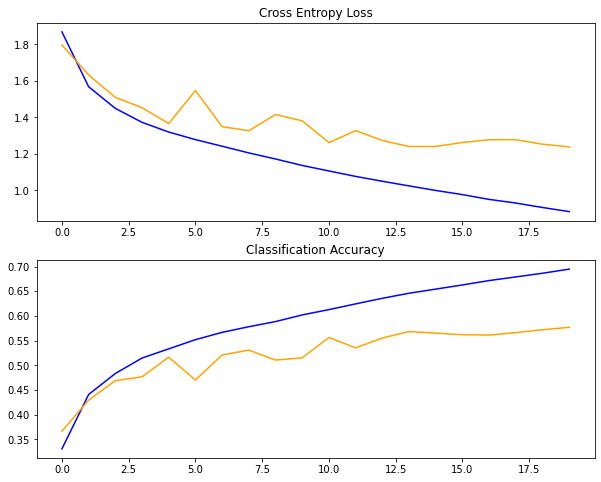

In [39]:
summarize_diagnostics(history)

Добавляю нормализацию по батчам

In [120]:
final_model_v2 = keras.Sequential()
final_model_v2.add(L.InputLayer(input_shape=(32, 32, 3)))
final_model_v2.add(L.convolutional.Conv2D(filters=10, kernel_size=(3, 3), activation='relu'))
final_model_v2.add(L.convolutional.Conv2D(filters=10, kernel_size=(3, 3), activation='relu'))
final_model_v2.add(L.BatchNormalization())
final_model_v2.add(L.MaxPooling2D((2, 2)))
final_model_v2.add(L.Flatten())
final_model_v2.add(L.Dense(100, activation='relu'))
final_model_v2.add(L.Dense(10, activation='softmax'))

final_model_v2.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [122]:
history2 = final_model_v2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStoppingValAcc(monitor='val_accuracy', value=0.8)],
    verbose=0
)

In [123]:
return_acc(final_model_v2, X_test, y_test)

0.5655

Увеличиваю количество фильтров с 10 до 32

In [124]:
final_model_v3 = keras.Sequential()
final_model_v3.add(L.InputLayer(input_shape=(32, 32, 3)))
final_model_v3.add(L.convolutional.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
final_model_v3.add(L.convolutional.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
final_model_v3.add(L.BatchNormalization())
final_model_v3.add(L.MaxPooling2D((2, 2)))

final_model_v3.add(L.Flatten())
final_model_v3.add(L.Dense(100, activation='relu'))
final_model_v3.add(L.Dense(10, activation='softmax'))

final_model_v3.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [125]:
history3 = final_model_v3.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStoppingValAcc(monitor='val_accuracy', value=0.8)],
    verbose=0
)

In [126]:
return_acc(final_model_v3, X_test, y_test)

0.6633

Точность постепенно растет, но до 80% еще далеко  
Добавляю еще один блок с 2мя сверточными слоями

In [127]:
final_model_v4 = keras.Sequential()
final_model_v4.add(L.InputLayer(input_shape=(32, 32, 3)))
final_model_v4.add(L.BatchNormalization())
final_model_v4.add(L.convolutional.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
final_model_v4.add(L.convolutional.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
final_model_v4.add(L.MaxPooling2D((2, 2)))
final_model_v4.add(L.Dropout(0.2))

final_model_v4.add(L.BatchNormalization())
final_model_v4.add(L.convolutional.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
final_model_v4.add(L.convolutional.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
final_model_v4.add(L.MaxPooling2D((2, 2)))
final_model_v4.add(L.Dropout(0.2))

final_model_v4.add(L.Flatten())
final_model_v4.add(L.Dense(100, activation='relu'))
final_model_v4.add(L.Dense(10, activation='softmax'))

final_model_v4.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [128]:
history4 = final_model_v4.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStoppingValAcc(monitor='val_accuracy', value=0.8)],
    verbose=0
)

In [129]:
return_acc(final_model_v4, X_test, y_test)

0.7833

В целом, на Kaggle при разборе этого кейса с cifar10 многие используют простую Sequential модель, при этом увеличивают количество блоков со сверточными слоями и количество фильтров внутри слоев.

Пробую количество блоков оставить прежним, увеличить количество фильтров и добавить еще больше batch_normalization 

In [130]:
final_model_v5 = keras.Sequential()

final_model_v5.add(L.InputLayer(input_shape=(32, 32, 3)))

final_model_v5.add(L.convolutional.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
final_model_v5.add(L.BatchNormalization())
final_model_v5.add(L.convolutional.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
final_model_v5.add(L.BatchNormalization())
final_model_v5.add(L.MaxPooling2D((2, 2)))
final_model_v5.add(L.Dropout(0.2))

final_model_v5.add(L.convolutional.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
final_model_v5.add(L.BatchNormalization())
final_model_v5.add(L.convolutional.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
final_model_v5.add(L.BatchNormalization())
final_model_v5.add(L.MaxPooling2D((2, 2)))
final_model_v5.add(L.Dropout(0.2))


final_model_v5.add(L.Flatten())
final_model_v5.add(L.Dense(100, activation='relu'))
final_model_v5.add(L.BatchNormalization())
final_model_v5.add(L.Dense(10, activation='softmax'))

final_model_v5.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [131]:
history5 = final_model_v5.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStoppingValAcc(monitor='val_accuracy', value=0.8)],
    verbose=0
)

Epoch 00035: early stopping THR


In [132]:
return_acc(final_model_v5, X_test, y_test)

0.8001

И внезапно это сработало! Еще и сошлось за меньшее количество эпох

Момент истины: проверьте, какого качества достигла ваша сеть.

In [133]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, final_model_v5.predict_classes(X_test))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.8001
Это победа!


In [134]:
final_model_v5.save('the_very_final_model_v5')

INFO:tensorflow:Assets written to: the_very_final_model_v5\assets


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

Результат достигнут, но кажется, что пока это больше благодаря везению нежели умению:) Надо больше практиковаться

В целом - рассмотрено, как может быть устроена сверточная сеть, как размер батча влияет на скорость сходимости, как  нормализация может изменить качество ответа. 